In [1]:
import numpy as np
import pandas as pd

reading data

In [2]:
emotion_df = pd.read_csv("1-P-3-ISEAR.csv",header=None)
emotion_df.head()

,0,1,2
0,0,joy,On days when I feel close to my partner and ot...
1,1,fear,Every time I imagine that someone I love or I ...
2,2,anger,When I had been obviously unjustly treated and...
3,3,sadness,When I think about the short time that we live...
4,4,disgust,At a gathering I found myself involuntarily si...


adding name to column

In [3]:
emotion_df.columns = ['sn','Target','Sentence']
emotion_df.drop('sn',inplace=True,axis =1)

In [4]:
emotion_df.head()

,Target,Sentence
0,joy,On days when I feel close to my partner and ot...
1,fear,Every time I imagine that someone I love or I ...
2,anger,When I had been obviously unjustly treated and...
3,sadness,When I think about the short time that we live...
4,disgust,At a gathering I found myself involuntarily si...


In [5]:
emotion_df['Target'].value_counts()

joy        1082
sadness    1074
anger      1069
fear       1063
shame      1059
disgust    1059
guilt      1040
Name: Target, dtype: int64

the data looks fairly balance

### Text Preprocessing

converting all sentences to lower case

In [6]:
def lowercase(text):
    '''a function lowercasing all characters'''
    text = text.lower()
    return text

emotion_df['Sentence'] = emotion_df['Sentence'].apply(lowercase)

removing punctuation and number from sentences

In [7]:
import string

def remove_punct_num(text):
    '''a function for removing punctuation and number'''
    text = "".join([char for char in text if char not in string.punctuation and not char.isdigit()])
    return text


emotion_df['Sentence'] = emotion_df['Sentence'].apply(remove_punct_num)

In [8]:
emotion_df.head()

,Target,Sentence
0,joy,on days when i feel close to my partner and ot...
1,fear,every time i imagine that someone i love or i ...
2,anger,when i had been obviously unjustly treated and...
3,sadness,when i think about the short time that we live...
4,disgust,at a gathering i found myself involuntarily si...


removing all stopwords

In [9]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Dell\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [10]:

def remove_stopwords(text):
    """
    Removing stopwords belonging to english language
    """
    text = [w for w in text.split() if w not in stopwords.words('english')]
    return ' '.join(text)

emotion_df['Sentence'] = emotion_df['Sentence'].apply(remove_stopwords)

In [11]:
emotion_df.head()

,Target,Sentence
0,joy,days feel close partner friends feel peace als...
1,fear,every time imagine someone love could contact ...
2,anger,obviously unjustly treated possibility elucida...
3,sadness,think short time live relate periods life thin...
4,disgust,gathering found involuntarily sitting next two...


Lemmatization i.e changing words into it's root form

In [12]:
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
from nltk.corpus import wordnet

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Dell\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [13]:
lemmatizer = WordNetLemmatizer()

def lemmatize(text):
    text = [lemmatizer.lemmatize(word,'v') for word in text.split()]
    return ' '.join(text)

emotion_df['Sentence'] = emotion_df['Sentence'].apply(lemmatize)

In [14]:
# from nltk import pos_tag,word_tokenize
# lemmatizer = WordNetLemmatizer()

# def lemmatize(text):
#     tmp_txt = []
#     for token,tag in pos_tag(word_tokenize(text)):
#         pos=tag[0].lower()
            
#         if pos not in ['a', 'r', 'n', 'v']:
#             pos='n'
        
#         tmp_txt.append(lemmatizer.lemmatize(token,pos))
#     return ' '.join(tmp_txt)

# emotion_df['Sentence'] = emotion_df['Sentence'].apply(lemmatize)


In [15]:
emotion_df.head()

,Target,Sentence
0,joy,days feel close partner friends feel peace als...
1,fear,every time imagine someone love could contact ...
2,anger,obviously unjustly treat possibility elucidate
3,sadness,think short time live relate periods life thin...
4,disgust,gather find involuntarily sit next two people ...


spliting data

In [16]:
from sklearn.model_selection import train_test_split
X = emotion_df['Sentence']
y = emotion_df['Target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2,random_state=10)


TFIDF 

It is technique to transform text into a meaningful vector of numbers.
TFIDF penalizes words that come up too often and don't really have much use. 
So it rescales the frequency of words that are common which makes scoring more balanced

In [17]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(min_df=2, max_df=0.5, ngram_range=(1, 2))
train_tfidf = tfidf.fit_transform(X_train)
test_tfidf = tfidf.transform(X_test)

### Model Building

In [18]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB

In [19]:
lr = LogisticRegression(max_iter=1000)
lr.fit(train_tfidf,y_train)
lr.score(train_tfidf, y_train), lr.score(test_tfidf, y_test)

(0.8529214237743452, 0.5697986577181208)

In [20]:
nb = MultinomialNB()
nb.fit(train_tfidf,y_train)
nb.score(train_tfidf, y_train), nb.score(test_tfidf, y_test)

(0.8299194089993284, 0.5691275167785235)

Test prediction of random sentence

In [21]:
test_sentence = ['i am very disappointed at you']
test_sentence = tfidf.transform(test_sentence)

lr.predict(test_sentence)


array(['disgust'], dtype=object)

In [22]:
#prediction prob 
lr_emotions = lr.predict_proba(test_sentence)
lr_datas = lr.classes_

lr_df = pd.DataFrame()
lr_df['Emotion'] = lr_datas
lr_df['emotion_propb'] = lr_emotions.T

In [23]:
lr_datas

array(['anger', 'disgust', 'fear', 'guilt', 'joy', 'sadness', 'shame'],
      dtype=object)

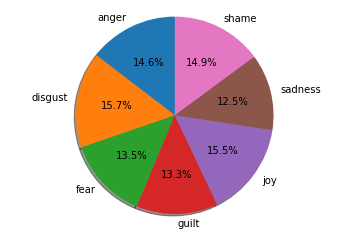

In [24]:
#pie chart for linear regression

import matplotlib.pyplot as plt

fig1, ax1 = plt.subplots()
ax1.pie(lr_df['emotion_propb'], labels=lr_df['Emotion'], autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()


In [25]:
nb_emotion = nb.predict_proba(test_sentence)
nb_datas = nb.classes_

nb_datas

array(['anger', 'disgust', 'fear', 'guilt', 'joy', 'sadness', 'shame'],
      dtype='<U7')

In [26]:
#prediction prob 
nb_emotions = lr.predict_proba(test_sentence)
nb_datas = lr.classes_

nb_df = pd.DataFrame()
nb_df['Emotion'] = nb_datas
nb_df['emotion_propb'] = nb_emotions.T

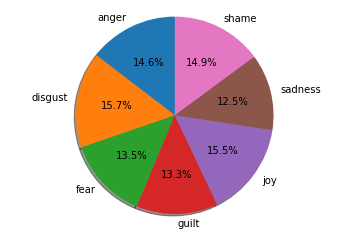

In [27]:
#pie chart for naive Bias

fig1, ax1 = plt.subplots()
ax1.pie(lr_df['emotion_propb'], labels=lr_df['Emotion'], autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()